# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [30]:

!pip install seaborn
!pip install scikeras
!pip install scikit-learn
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv('/content/drive/My Drive/icml_face_data.csv')
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)


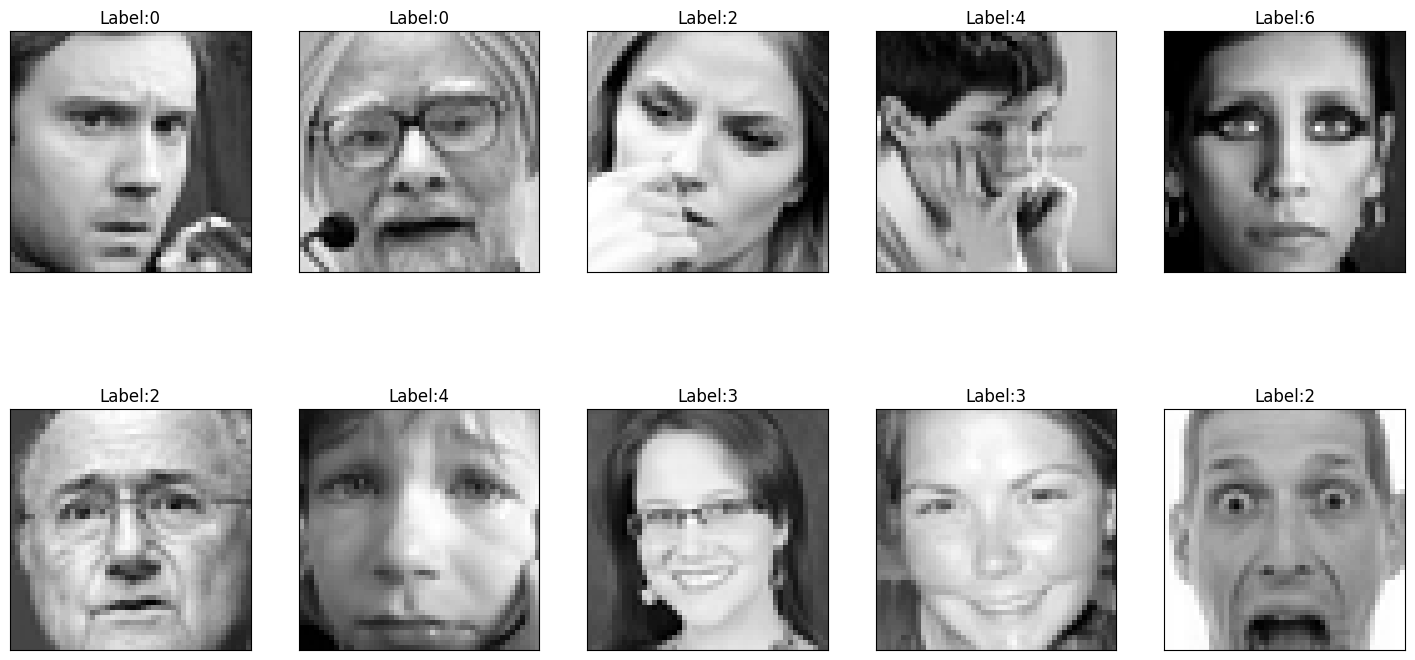

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:

# Flatten hình ảnh thành mảng 2 chiều
n_samples, height, width = images.shape
images_flattened = images.reshape(n_samples, height * width)

# Áp dụng PCA
pca_2_components = PCA(n_components=2)
pca_2_components = pca_2_components.fit(images_flattened)

In [ ]:
## transform for visualizing here
images_pca_2_components=pca_2_components.transform(images_flattened) ## modify images' array to the appropriate shape
images_pca_2_components.shape
images_pca_2_components

array([[ -691.75085917,  -442.3286447 ],
       [   62.02548935,   561.76220441],
       [ 1322.53807047,  -415.72967713],
       ...,
       [ 1289.15565244, -1408.56831159],
       [-2008.41357066,  -125.61091323],
       [  210.23902665,  -486.56908826]])

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [ ]:
## determine the optimal number of PCs here

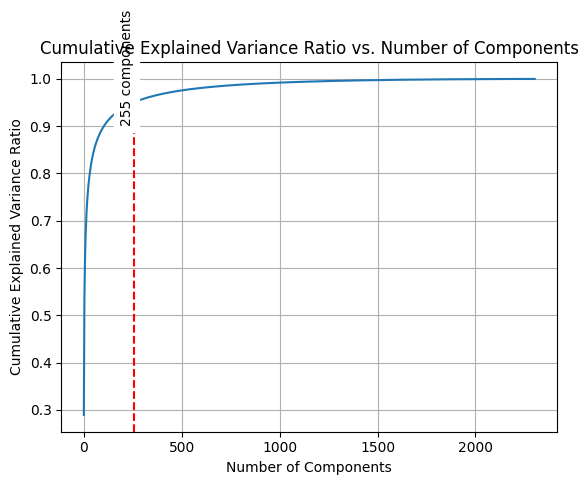

Number of components to retain 95% of the data variance: 255


In [ ]:
# Flatten images into a 2D array
n_samples, height, width = images.shape
images_flattened = images.reshape(n_samples, height * width)

# Apply PCA
pca = PCA()
pca.fit(images_flattened)

# Plot cumulative explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)

# Find the number of components to retain 95% of the data variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

plt.axvline(x=n_components_95, color='red', linestyle='--')
plt.text(n_components_95, 0.90, f'{n_components_95} components', rotation=90, va='bottom', ha='right', backgroundcolor='white')

plt.show()

print(f'Number of components to retain 95% of the data variance: {n_components_95}')

In [ ]:
## Explain the selection process

At first, we choose a threshold of 95% variance to balance between reducing dimensions and preserving information. Then we use ```pca.explained_variance_``` to measure how much of the total variance in the original dataset is explained by each principal component. Next, we draw the cumulative explained variance plot to show adding more components captures more variance in the data.  
Finally, the result comes out to be 255 components. This number also sits right on the knee of the curve (The knee means even if you add more components, it won't help explain the data variance any much more).  This is the optimal number of principal components using ```pca.explained_variance_```.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### 3.1 Build models

In [ ]:
pca_opt = PCA(n_components=n_components_95)
images_pca = pca_opt.fit_transform(images_flattened)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca, labels, test_size=0.2, random_state=42)

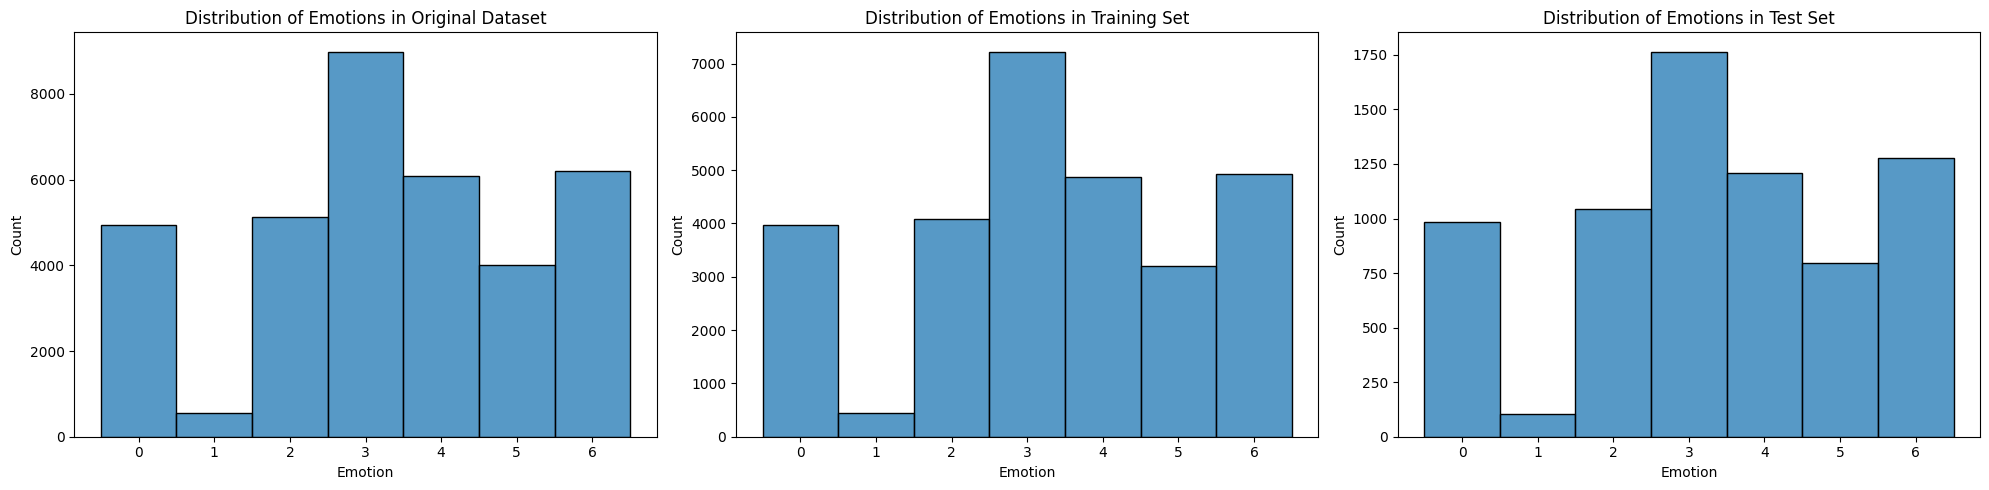

In [ ]:
# Create DataFrames for easier handling
original_labels_df = pd.DataFrame({'emotion': labels})
train_labels_df = pd.DataFrame({'emotion': y_train})
test_labels_df = pd.DataFrame({'emotion': y_test})

# Plotting the distribution of emotions
plt.figure(figsize=(20, 5))

# Original dataset
plt.subplot(1, 3, 1)
sns.histplot(original_labels_df['emotion'], bins=np.arange(-0.5, len(np.unique(labels)), 1), kde=False)
plt.title('Distribution of Emotions in Original Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Training set
plt.subplot(1, 3, 2)
sns.histplot(train_labels_df['emotion'], bins=np.arange(-0.5, len(np.unique(y_train)), 1), kde=False)
plt.title('Distribution of Emotions in Training Set')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Test set
plt.subplot(1, 3, 3)
sns.histplot(test_labels_df['emotion'], bins=np.arange(-0.5, len(np.unique(y_test)), 1), kde=False)
plt.title('Distribution of Emotions in Test Set')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

The proportions of different emotions in the original data, test set, and train set are similar. This helps ensure that the model trained on the training set can generalize well to unseen data and the evaluation metrics on the test set will accurately reflect the model's performance.

#### 3.1.1 Machine learning model (Random Forest)

##### First Random Forest Model

In [ ]:
def get_accuracy_random_forest(X_train, X_test, y_train, y_test, params):
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Single set of random parameters to try
params_1 = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}

# Get accuracy on original data
accuracy_original_1 = get_accuracy_random_forest(X_train, X_test, y_train, y_test, params_1)
print(f'Accuracy on original data: {accuracy_original_1:.4f}')

# Get accuracy on PCA data
accuracy_pca_1 = get_accuracy_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_1)
print(f'Accuracy on PCA data: {accuracy_pca_1:.4f}')

Accuracy on original data: 0.4524
Accuracy on PCA data: 0.3858


##### Second Random Forest Model

In [ ]:
# Single set of random parameters to try
params_2 = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5} # Change this line from a tuple to a dictionary

# Get accuracy on original data
accuracy_original_2 = get_accuracy_random_forest(X_train, X_test, y_train, y_test, params_2)
print(f'Accuracy on original data: {accuracy_original_2:.4f}')

# Get accuracy on PCA data
accuracy_pca_2 = get_accuracy_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_2)
print(f'Accuracy on PCA data: {accuracy_pca_2:.4f}')

Accuracy on original data: 0.4058
Accuracy on PCA data: 0.3281


##### Third Random Forest Model

In [ ]:
# Single set of random parameters to try
params_3 = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}  # Changed to dictionary

# Get accuracy on original data
accuracy_original_3 = get_accuracy_random_forest(X_train, X_test, y_train, y_test, params_3)
print(f'Accuracy on original data: {accuracy_original_3:.4f}')

# Get accuracy on PCA data
accuracy_pca_3 = get_accuracy_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_3)
print(f'Accuracy on PCA data: {accuracy_pca_3:.4f}')

Accuracy on original data: 0.4635
Accuracy on PCA data: 0.3936


#### 3.1.2 MLP model (CNN)

In [ ]:
# Extract features (pixels) and labels (emotion)
X = np.array(df['pixels'].apply(lambda x: np.fromstring(x, sep=' ')))
X = np.vstack(X)  # Reshape to a 2D array of shape (n_samples, n_features)
X = X.reshape(-1, 48, 48, 1)  # Reshape to images with single channel (grayscale)
y = to_categorical(df['emotion'])  # Convert labels to categorical

# Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks (optional)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history_1 = model.fit(X_train_cnn, y_train_cnn,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_cnn, y_test_cnn),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score_1 = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("Test accuracy using CNN model on original data:", score_1[1])

In [ ]:
# Extract features (pixels) and labels (emotion)
X = np.array(df['pixels'].apply(lambda x: np.fromstring(x, sep=' ')))
X = np.vstack(X)  # Reshape to a 2D array of shape (n_samples, n_features)
X = X.reshape(-1, 48, 48, 1)  # Reshape to images with single channel (grayscale)
y = to_categorical(df['emotion'])  # Convert labels to categorical

# Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks (optional)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history_1 = model.fit(X_train_cnn, y_train_cnn,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_cnn, y_test_cnn),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score_1 = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("Test accuracy using CNN model on original data:", score_1[1])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 105s 115ms/step - accuracy: 0.2906 - loss: 2.7202 - val_accuracy: 0.4126 - val_loss: 1.5463
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.4321 - loss: 1.4685 - val_accuracy: 0.4654 - val_loss: 1.3981
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.4912 - loss: 1.3324 - val_accuracy: 0.4905 - val_loss: 1.3398
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 145s 115ms/step - accuracy: 0.5218 - loss: 1.2611 - val_accuracy: 0.4989 - val_loss: 1.3123
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - accuracy: 0.5571 - loss: 1.1657 - val_accuracy: 0.5054 - val_loss: 1.3020
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 144s 110ms/step - accuracy: 0.5837 - loss: 1.1000 - val_accuracy: 0.5146 - val_loss: 1.3094
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.6118 - loss: 1.0269 - val_accuracy: 0.5063 - val_loss: 1.3475
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - accuracy: 0.6479 - l

In [ ]:
# Reshape PCA-transformed data back to 48x48 images
X_train_images = pca_opt.inverse_transform(X_train_pca).reshape(-1, 48, 48, 1)
X_test_images = pca_opt.inverse_transform(X_test_pca).reshape(-1, 48, 48, 1)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train_pca, num_classes=7)
y_test_categorical = to_categorical(y_test_pca, num_classes=7)

# Train the model
history_2 = model.fit(X_train_images, y_train_categorical,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_images, y_test_categorical),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score_2 = model.evaluate(X_test_images, y_test_categorical, verbose=0)
print("Test accuracy using CNN model on PCA-transformed data:", score_2[1])

### 3.2 Hyperparameter tuning using GridCV

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model and its accuracy on original data
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)

# Create and fit GridSearchCV on PCA data
grid_search_pca = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_pca.fit(X_train_pca, y_train_pca)

# Get the best model and its accuracy on PCA data
best_rf_pca = grid_search_pca.best_estimator_
y_pred_pca = best_rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)

print(f'Accuracy on original data (after GridSearchCV): {accuracy_original:.4f}')
print(f'Accuracy on PCA data (after GridSearchCV): {accuracy_pca:.4f}')

Fitting 3 folds for each of 81 candidates, totalling 243 fits


ValueError: 
All the 243 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
243 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 345, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 915, in check_array
    raise ValueError(
ValueError: Found array with dim 4. RandomForestClassifier expected <= 2.


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define a function to create the Keras model
def create_cnn_model(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(7, activation='softmax'))  # Assuming there are 7 emotion classes

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap Keras model using KerasClassifier
model = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Define parameters for GridSearchCV
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [20, 30],
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
grid_result = grid.fit(X_train_images, y_train)

# Print results
print('Best score = {:.4f} using {}'.format(grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. Whe

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 928, in _fit
    self._fit_keras_model(
  File "C:\Users\Admin\anaconda3\Lib\site-packages\scikeras\wrappers.py", line 524, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 619, in sparse_categorical_crossentropy
    raise ValueError(
ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 7), output.shape=(None, 7)


We encountered some warnings that we couldn't fully understand or fix. The first warns about the future renaming of build_fn to model in SciKeras, and the second advises against passing input_shape directly to a layer in Keras. Despite trying different approaches, we couldn't resolve them.

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [1]:
## visualize the confusion matrices and classification reports here

In [32]:
def get_metrics_random_forest(X_train, X_test, y_train, y_test, params):
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1
# Single set of random parameters to try
params_1 = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}

accuracy_original_1, precision_original_1, recall_original_1, f1_original_1 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_1)
print(f'Accuracy on original data: {accuracy_original_1:.4f}')
print(f'Precision on original data: {precision_original_1:.4f}')
print(f'Recall on original data: {recall_original_1:.4f}')
print(f'F1-score on original data: {f1_original_1:.4f}')

# Get metrics on PCA data
accuracy_pca_1, precision_pca_1, recall_pca_1, f1_pca_1 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_1)
print(f'Accuracy on PCA data: {accuracy_pca_1:.4f}')
print(f'Precision on PCA data: {precision_pca_1:.4f}')
print(f'Recall on PCA data: {recall_pca_1:.4f}')
print(f'F1-score on PCA data: {f1_pca_1:.4f}')

Accuracy on original data: 0.4447
Precision on original data: 0.4744
Recall on original data: 0.4447
F1-score on original data: 0.4201
Accuracy on PCA data: 0.3789
Precision on PCA data: 0.4941
Recall on PCA data: 0.3789
F1-score on PCA data: 0.3333


In [ ]:
#

In [33]:
# Single set of random parameters to try
params_2 = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5}

accuracy_original_2, precision_original_2, recall_original_2, f1_original_2 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_2)
print(f'Accuracy on original data: {accuracy_original_2:.4f}')
print(f'Precision on original data: {precision_original_2:.4f}')
print(f'Recall on original data: {recall_original_2:.4f}')
print(f'F1-score on original data: {f1_original_2:.4f}')

# Get metrics on PCA data
accuracy_pca_2, precision_pca_2, recall_pca_2, f1_pca_2 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_2)
print(f'Accuracy on PCA data: {accuracy_pca_2:.4f}')
print(f'Precision on PCA data: {precision_pca_2:.4f}')
print(f'Recall on PCA data: {recall_pca_2:.4f}')
print(f'F1-score on PCA data: {f1_pca_2:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy on original data: 0.4058
Precision on original data: 0.4570
Recall on original data: 0.4058
F1-score on original data: 0.3627
Accuracy on PCA data: 0.3281
Precision on PCA data: 0.4890
Recall on PCA data: 0.3281
F1-score on PCA data: 0.2544


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Single set of random parameters to try
params_3 = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}  # Changed to dictionary

accuracy_original_3, precision_original_3, recall_original_3, f1_original_3 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_3)
print(f'Accuracy on original data: {accuracy_original_3:.4f}')
print(f'Precision on original data: {precision_original_3:.4f}')
print(f'Recall on original data: {recall_original_3:.4f}')
print(f'F1-score on original data: {f1_original_3:.4f}')

# Get metrics on PCA data
accuracy_pca_3, precision_pca_3, recall_pca_3, f1_pca_3 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_3)
print(f'Accuracy on PCA data: {accuracy_pca_3:.4f}')
print(f'Precision on PCA data: {precision_pca_3:.4f}')
print(f'Recall on PCA data: {recall_pca_3:.4f}')
print(f'F1-score on PCA data: {f1_pca_3:.4f}')

Accuracy on original data: 0.4635
Precision on original data: 0.5032
Recall on original data: 0.4635
F1-score on original data: 0.4387
Accuracy on PCA data: 0.3936
Precision on PCA data: 0.5198
Recall on PCA data: 0.3936
F1-score on PCA data: 0.3513


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_confusion_matrix_and_report(y_test, y_pred, title):

    cm = confusion_matrix(y_test, y_pred)

    cr = classification_report(y_test, y_pred, target_names=[str(i) for i in range(7)])


    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(7)], yticklabels=[str(i) for i in range(7)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


    print(f"Classification Report - {title}:")
    print(cr)

def get_metrics_random_forest(X_train, X_test, y_train, y_test, params):
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') # Calculate precision
    recall = recall_score(y_test, y_pred, average='weighted')     # Calculate recall
    f1 = f1_score(y_test, y_pred, average='weighted')             # Calculate F1-score

    return accuracy, precision, recall, f1, y_pred # Return all calculated metrics and predictions




Accuracy on original data: 0.4489
Precision on original data: 0.4805
Recall on original data: 0.4489
F1-score on original data: 0.4227


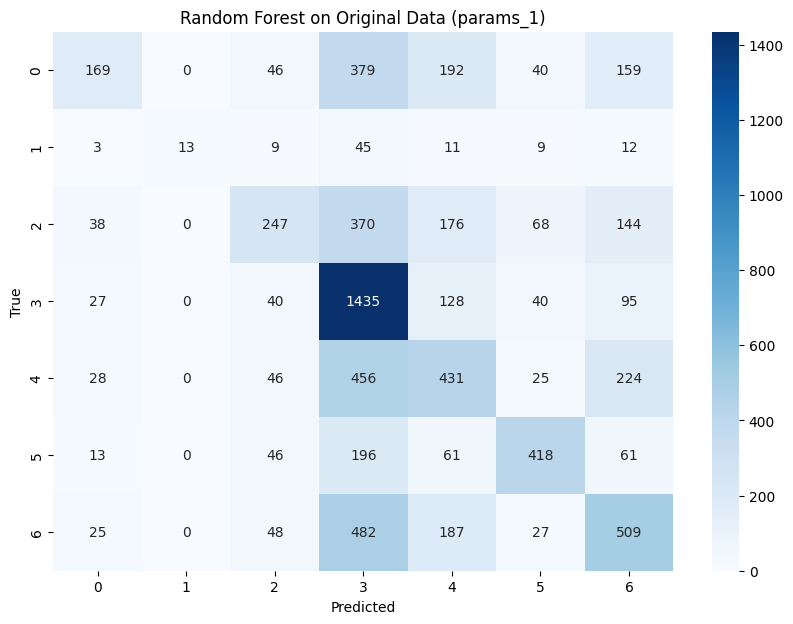

Classification Report - Random Forest on Original Data (params_1):
              precision    recall  f1-score   support

           0       0.56      0.17      0.26       985
           1       1.00      0.13      0.23       102
           2       0.51      0.24      0.32      1043
           3       0.43      0.81      0.56      1765
           4       0.36      0.36      0.36      1210
           5       0.67      0.53      0.59       795
           6       0.42      0.40      0.41      1278

    accuracy                           0.45      7178
   macro avg       0.56      0.38      0.39      7178
weighted avg       0.48      0.45      0.42      7178

Accuracy on PCA data: 0.3760
Precision on PCA data: 0.4855
Recall on PCA data: 0.3760
F1-score on PCA data: 0.3311


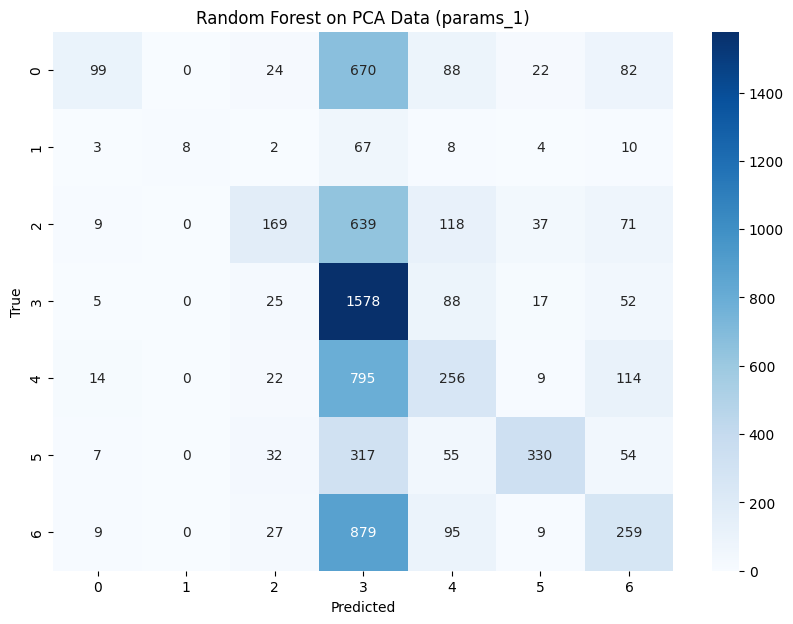

Classification Report - Random Forest on PCA Data (params_1):
              precision    recall  f1-score   support

           0       0.68      0.10      0.18       985
           1       1.00      0.08      0.15       102
           2       0.56      0.16      0.25      1043
           3       0.32      0.89      0.47      1765
           4       0.36      0.21      0.27      1210
           5       0.77      0.42      0.54       795
           6       0.40      0.20      0.27      1278

    accuracy                           0.38      7178
   macro avg       0.58      0.29      0.30      7178
weighted avg       0.49      0.38      0.33      7178

Accuracy on original data: 0.4071
Precision on original data: 0.4597
Recall on original data: 0.4071
F1-score on original data: 0.3649


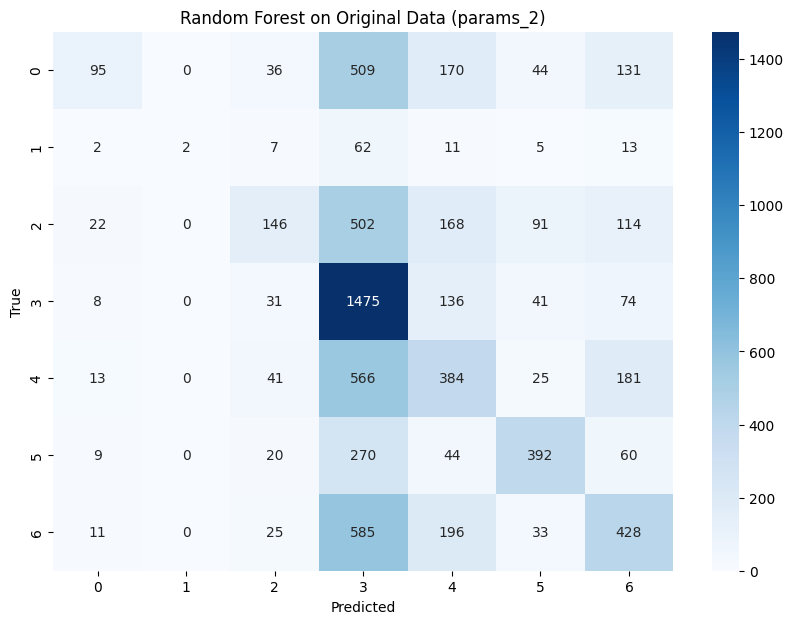

Classification Report - Random Forest on Original Data (params_2):
              precision    recall  f1-score   support

           0       0.59      0.10      0.17       985
           1       1.00      0.02      0.04       102
           2       0.48      0.14      0.22      1043
           3       0.37      0.84      0.51      1765
           4       0.35      0.32      0.33      1210
           5       0.62      0.49      0.55       795
           6       0.43      0.33      0.38      1278

    accuracy                           0.41      7178
   macro avg       0.55      0.32      0.31      7178
weighted avg       0.46      0.41      0.36      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Accuracy on PCA data: 0.3203
Precision on PCA data: 0.4946
Recall on PCA data: 0.3203
F1-score on PCA data: 0.2408


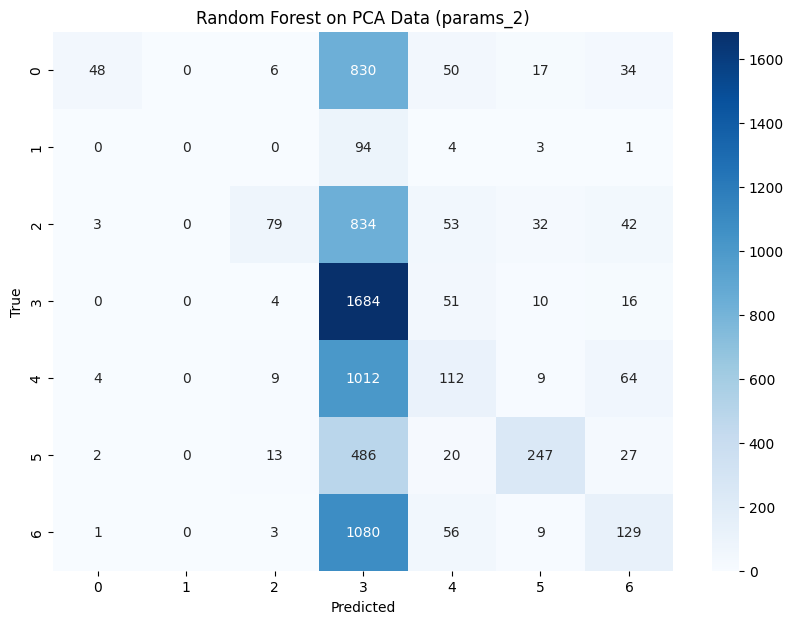

Classification Report - Random Forest on PCA Data (params_2):
              precision    recall  f1-score   support

           0       0.83      0.05      0.09       985
           1       0.00      0.00      0.00       102
           2       0.69      0.08      0.14      1043
           3       0.28      0.95      0.43      1765
           4       0.32      0.09      0.14      1210
           5       0.76      0.31      0.44       795
           6       0.41      0.10      0.16      1278

    accuracy                           0.32      7178
   macro avg       0.47      0.23      0.20      7178
weighted avg       0.49      0.32      0.24      7178

Accuracy on original data: 0.4607
Precision on original data: 0.4960
Recall on original data: 0.4607
F1-score on original data: 0.4357


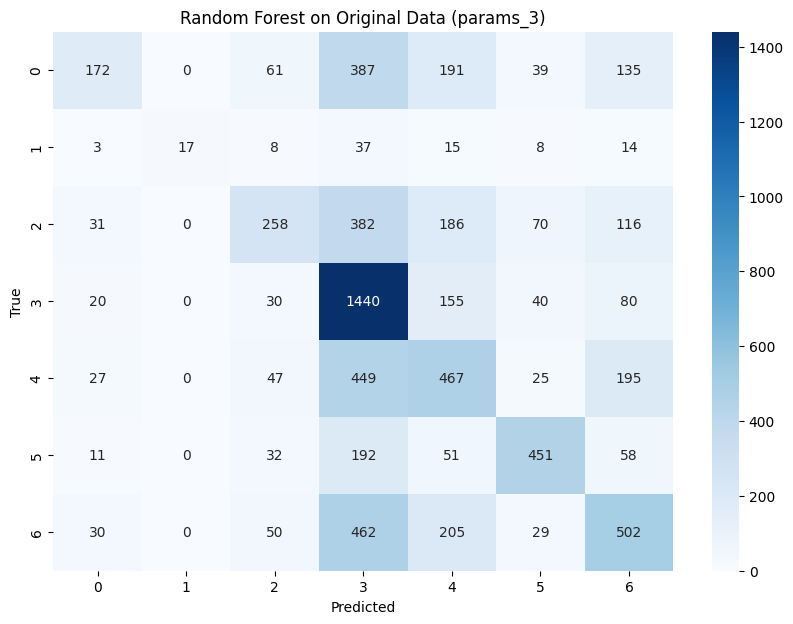

Classification Report - Random Forest on Original Data (params_3):
              precision    recall  f1-score   support

           0       0.59      0.17      0.27       985
           1       1.00      0.17      0.29       102
           2       0.53      0.25      0.34      1043
           3       0.43      0.82      0.56      1765
           4       0.37      0.39      0.38      1210
           5       0.68      0.57      0.62       795
           6       0.46      0.39      0.42      1278

    accuracy                           0.46      7178
   macro avg       0.58      0.39      0.41      7178
weighted avg       0.50      0.46      0.44      7178

Accuracy on PCA data: 0.3926
Precision on PCA data: 0.5151
Recall on PCA data: 0.3926
F1-score on PCA data: 0.3519


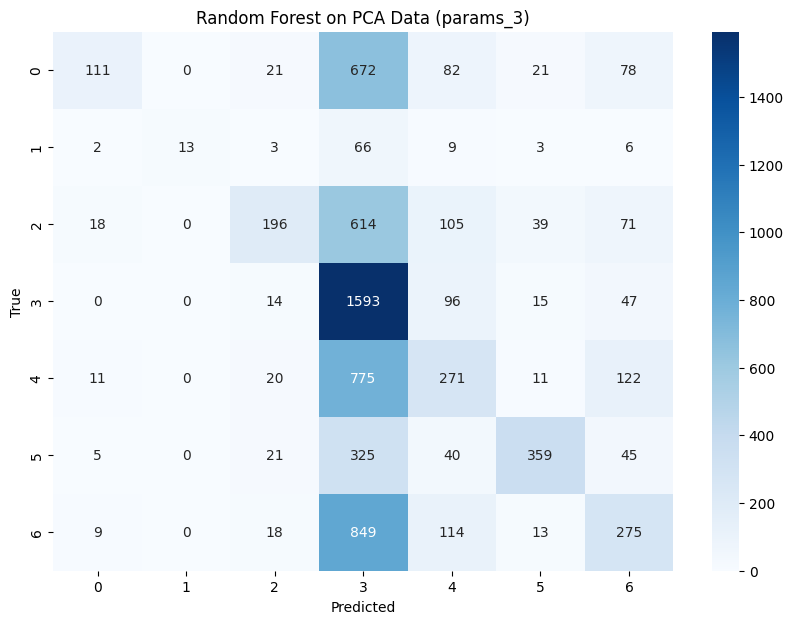

Classification Report - Random Forest on PCA Data (params_3):
              precision    recall  f1-score   support

           0       0.71      0.11      0.19       985
           1       1.00      0.13      0.23       102
           2       0.67      0.19      0.29      1043
           3       0.33      0.90      0.48      1765
           4       0.38      0.22      0.28      1210
           5       0.78      0.45      0.57       795
           6       0.43      0.22      0.29      1278

    accuracy                           0.39      7178
   macro avg       0.61      0.32      0.33      7178
weighted avg       0.52      0.39      0.35      7178



In [46]:
# Single set of random parameters to try
params_1 = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}

accuracy_original_1, precision_original_1, recall_original_1, f1_original_1, y_pred_original_1 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_1)
print(f'Accuracy on original data: {accuracy_original_1:.4f}')
print(f'Precision on original data: {precision_original_1:.4f}')
print(f'Recall on original data: {recall_original_1:.4f}')
print(f'F1-score on original data: {f1_original_1:.4f}')
plot_confusion_matrix_and_report(y_test, y_pred_original_1, 'Random Forest on Original Data (params_1)')

accuracy_pca_1, precision_pca_1, recall_pca_1, f1_pca_1, y_pred_pca_1 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_1)
print(f'Accuracy on PCA data: {accuracy_pca_1:.4f}')
print(f'Precision on PCA data: {precision_pca_1:.4f}')
print(f'Recall on PCA data: {recall_pca_1:.4f}')
print(f'F1-score on PCA data: {f1_pca_1:.4f}')
plot_confusion_matrix_and_report(y_test_pca, y_pred_pca_1, 'Random Forest on PCA Data (params_1)')

# Single set of random parameters to try
params_2 = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 5}

accuracy_original_2, precision_original_2, recall_original_2, f1_original_2, y_pred_original_2 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_2)
print(f'Accuracy on original data: {accuracy_original_2:.4f}')
print(f'Precision on original data: {precision_original_2:.4f}')
print(f'Recall on original data: {recall_original_2:.4f}')
print(f'F1-score on original data: {f1_original_2:.4f}')
plot_confusion_matrix_and_report(y_test, y_pred_original_2, 'Random Forest on Original Data (params_2)')

accuracy_pca_2, precision_pca_2, recall_pca_2, f1_pca_2, y_pred_pca_2 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_2)
print(f'Accuracy on PCA data: {accuracy_pca_2:.4f}')
print(f'Precision on PCA data: {precision_pca_2:.4f}')
print(f'Recall on PCA data: {recall_pca_2:.4f}')
print(f'F1-score on PCA data: {f1_pca_2:.4f}')
plot_confusion_matrix_and_report(y_test_pca, y_pred_pca_2, 'Random Forest on PCA Data (params_2)')

# Single set of random parameters to try
params_3 = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}  # Changed to dictionary

accuracy_original_3, precision_original_3, recall_original_3, f1_original_3, y_pred_original_3 = get_metrics_random_forest(X_train, X_test, y_train, y_test, params_3)
print(f'Accuracy on original data: {accuracy_original_3:.4f}')
print(f'Precision on original data: {precision_original_3:.4f}')
print(f'Recall on original data: {recall_original_3:.4f}')
print(f'F1-score on original data: {f1_original_3:.4f}')
plot_confusion_matrix_and_report(y_test, y_pred_original_3, 'Random Forest on Original Data (params_3)')

accuracy_pca_3, precision_pca_3, recall_pca_3, f1_pca_3, y_pred_pca_3 = get_metrics_random_forest(X_train_pca, X_test_pca, y_train_pca, y_test_pca, params_3)
print(f'Accuracy on PCA data: {accuracy_pca_3:.4f}')
print(f'Precision on PCA data: {precision_pca_3:.4f}')
print(f'Recall on PCA data: {recall_pca_3:.4f}')
print(f'F1-score on PCA data: {f1_pca_3:.4f}')
plot_confusion_matrix_and_report(y_test_pca, y_pred_pca_3, 'Random Forest on PCA Data (params_3)')


225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step
Accuracy on original data: 0.5054
Precision on original data: 0.5076
Recall on original data: 0.5054
F1-score on original data: 0.5013


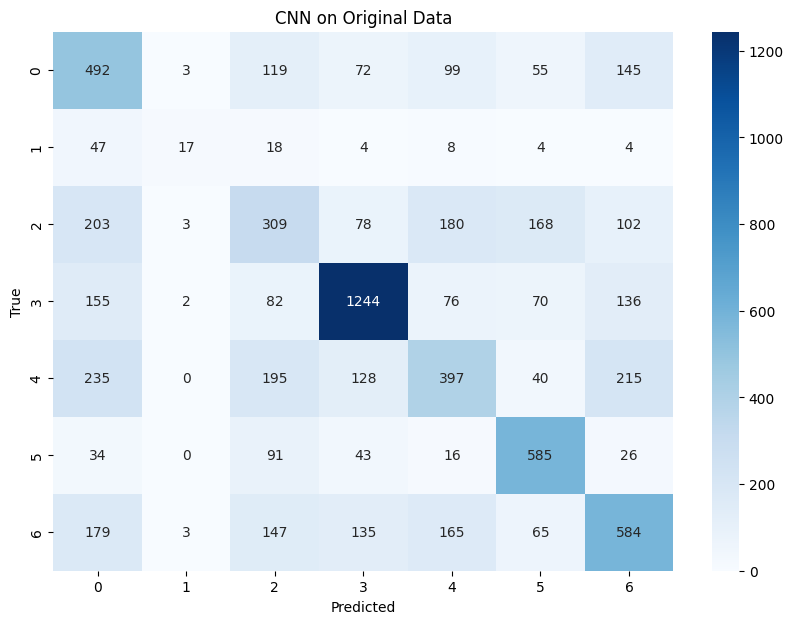

Classification Report - CNN on Original Data:
              precision    recall  f1-score   support

           0       0.37      0.50      0.42       985
           1       0.61      0.17      0.26       102
           2       0.32      0.30      0.31      1043
           3       0.73      0.70      0.72      1765
           4       0.42      0.33      0.37      1210
           5       0.59      0.74      0.66       795
           6       0.48      0.46      0.47      1278

    accuracy                           0.51      7178
   macro avg       0.50      0.46      0.46      7178
weighted avg       0.51      0.51      0.50      7178



ValueError: cannot reshape array of size 1830390 into shape (7178,48,48,1)

In [51]:
# Convert probabilities to class labels for the original data
y_pred_original = model.predict(X_test_cnn)
y_pred_classes_original = np.argmax(y_pred_original, axis=1)

# Calculate evaluation metrics for the original data
accuracy_original = accuracy_score(np.argmax(y_test_cnn, axis=1), y_pred_classes_original)
precision_original = precision_score(np.argmax(y_test_cnn, axis=1), y_pred_classes_original, average='weighted')
recall_original = recall_score(np.argmax(y_test_cnn, axis=1), y_pred_classes_original, average='weighted')
f1_original = f1_score(np.argmax(y_test_cnn, axis=1), y_pred_classes_original, average='weighted')
print(f'Accuracy on original data: {accuracy_original:.4f}')
print(f'Precision on original data: {precision_original:.4f}')
print(f'Recall on original data: {recall_original:.4f}')
print(f'F1-score on original data: {f1_original:.4f}')

# Display confusion matrix and classification report for the original data
plot_confusion_matrix_and_report(np.argmax(y_test_cnn, axis=1), y_pred_classes_original, 'CNN on Original Data')

# Convert probabilities to class labels for the PCA data
width = 48  # Replace with the actual width of your images
height = 48 # Replace with the actual height of your images
channels = 1  # Replace with the actual number of channels in your images (e.g., 1 for grayscale, 3 for RGB)

# Reshape X_test_pca to match the expected input shape
y_pred_pca = model.predict(X_test_pca.reshape(X_test_pca.shape[0], width, height, channels))

y_pred_classes_pca = np.argmax(y_pred_pca, axis=1)

# Calculate evaluation metrics for the PCA data
accuracy_pca = accuracy_score(np.argmax(y_test_categorical, axis=1), y_pred_classes_pca)
precision_pca = precision_score(np.argmax(y_test_categorical, axis=1), y_pred_classes_pca, average='weighted')
recall_pca = recall_score(np.argmax(y_test_categorical, axis=1), y_pred_classes_pca, average='weighted')
f1_pca = f1_score(np.argmax(y_test_categorical, axis=1), y_pred_classes_pca, average='weighted')
print(f'Accuracy on PCA data: {accuracy_pca:.4f}')
print(f'Precision on PCA data: {precision_pca:.4f}')
print(f'Recall on PCA data: {recall_pca:.4f}')
print(f'F1-score on PCA data: {f1_pca:.4f}')

# Display confusion matrix and classification report for the PCA data
plot_confusion_matrix_and_report(np.argmax(y_test_categorical, axis=1), y_pred_classes_pca, 'CNN on PCA Data')

Based on the evaluation metrics, the MLP model has the best performance. The model performs worst for the "Disgust" emotion category, as shown by the low recall (0.17) and F1-score (0.26). The low recall indicates that the model fails to identify most of the disgust faces in the dataset, leading to many false negatives. Although the precision (0.61) is relatively higher, it doesn't compensate for the very low recall, making this category the most challenging for the model.